In [18]:
import numpy as np
import pandas as pd
import utm
import math
import pickle
import os
import sys
sys.path.append('./src')
import time
import datetime
from collections import defaultdict
import matplotlib
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import copy

import display_gm
import display_osm
import plot
import tools
import pygrid
import split, uni_hmm
import celltower as ctcrawler
from data_cleaning import noise, load, counter

# Load Data

In [2]:
load = reload(load)
dataset = 'jiading'
datatype = '2g'
data_file = './data/%s_%s/data_%s.csv' % (dataset, datatype, datatype)
gongcan_file = './data/%s_%s/gongcan_%s.csv' % (dataset, datatype, datatype)
disp_path = './display/%s_%s/' % (dataset, datatype)
data_path = './data/%s_%s/' % (dataset, datatype)
map_file = './data/%s_map/%s_EdgeGeometry.txt' % (dataset, dataset)

In [76]:
db, db_gps, towers = load.load_data(data_file, gongcan_file, merge_tower=False, neighbor=True, with_rssi=True, radio_angle=False, context=False)
print 'len(db):', len(db), 'len(towers):', len(towers)

Unique Cell Tower:  81
Duplicated cell towers: [[66, 67, 68], [35, 36], [53, 54], [69, 70, 71], [40, 41], [56, 57], [61, 62, 63]]
Totally duplicate: 86
len(db): 72 len(towers): 91


In [77]:
db_gps[0][:5]

[(31.29184524, 121.21368387, 62, -80, 70, -90, 0.0, 1507627341L),
 (31.28926598, 121.21361016, 62, -80, 70, -90, 0.68, 1507627346L),
 (31.28922812, 121.21357512, 63, -80, 70, -90, 0.0, 1507627351L),
 (31.28926254, 121.21358264, 63, -80, 70, -90, 0.0, 1507627356L),
 (31.28928476, 121.21360502, 63, -80, 70, -90, 0.0, 1507627359L)]

In [80]:
df = pd.read_csv(data_file)
display_osm.df_to_html(df, disp_path + 'gps.html')

# Data Cleaning
* 两点间最大距离小于max_dist
* bounding_box大于min_dist
* GPS point 大于min_len

In [78]:
noise = reload(noise)
max_dist, min_dist, min_len, max_again = noise.get_config(dataset, datatype)
dbs = noise.clean_db(db, max_dist, min_dist, min_len, max_again, debug=True)
dbs_gps = noise.clean_db_gps(db_gps, max_dist, min_dist, min_len, max_again, debug=False)
len(dbs), len(dbs_gps)

Traj ID=0
0->1:286m	
discard[0:0]=0m	keep[1:25]as id=0	
Traj ID=1
7->8:510m	
discard[0:7]=0m	keep[8:158]as id=1	
Traj ID=2
1->2:330m	
discard[0:1]=0m	keep[2:78]as id=2	
Traj ID=3

keep[0:34]as id=3	
Traj ID=4
0->1:394m	
discard[0:0]=0m	keep[1:45]as id=4	
Traj ID=5
1->2:118m	
discard[0:1]=0m	keep[2:50]as id=5	
Traj ID=6
1->2:522m	112->113:752m	133->134:116m	
discard[0:1]=0m	trimed[0,89] keep[2:23]as id=6	discard[113:133]=33m	discard[134:135]=0m	
Traj ID=7
9->10:101m	
discard[0:9]=0m	keep[10:113]as id=7	
Traj ID=8

keep[0:374]as id=8	
Traj ID=9
1->2:947m	
discard[0:1]=0m	keep[2:342]as id=9	
Traj ID=10

keep[0:421]as id=10	
Traj ID=11

keep[0:296]as id=11	
Traj ID=12

keep[0:423]as id=12	
Traj ID=13
35->36:838m	
discard[0:35]=0m	keep[36:1016]as id=13	
Traj ID=14

keep[0:827]as id=14	
Traj ID=15
42->43:667m	
keep[0:43]as id=15	keep[43:115]as id=16	
Traj ID=16
2->3:482m	345->346:714m	
discard[0:2]=0m	keep[3:346]as id=17	keep[346:854]as id=18	
Traj ID=17

trimed[1,12] keep[1:234]as id=19	
Tr

(74, 74)

In [79]:
db_gps[0][:5]

[(31.29184524, 121.21368387, 62, -80, 70, -90, 0.0, 1507627341L),
 (31.28926598, 121.21361016, 62, -80, 70, -90, 0.68, 1507627346L),
 (31.28922812, 121.21357512, 63, -80, 70, -90, 0.0, 1507627351L),
 (31.28926254, 121.21358264, 63, -80, 70, -90, 0.0, 1507627356L),
 (31.28928476, 121.21360502, 63, -80, 70, -90, 0.0, 1507627359L)]

In [84]:
load = reload(load)
load.for_map_matching(dbs_gps, data_path + 'trajs')

# Display

In [85]:
tl = []
for ids, val in towers.iteritems():
    rncid, cellid = ids
    idx, lat, lng, _, _ = val
    tl.append((idx, lat ,lng, rncid, cellid))
tower_df = pd.DataFrame(tl, columns=['Index', 'Latitude', 'Longitude', 'RNCID', 'CellID'])

In [86]:
display_osm = reload(display_osm)

In [87]:
display_osm.gongcan_to_html(tower_df, disp_path + 'towers.html')

In [7]:
bounding_box = (328000, 331000, 3462000, 3465000)
# bounding_box = (356000, 359000, 3461500, 3463000)
side = 30
grid = pygrid.Grid(side, bounding_box)

In [8]:
load = reload(load)
roadmap = load.load_map(map_file)
slice_map = tools.make_map(grid, roadmap, 120, 1)
print len(roadmap)

214


In [142]:
plot = reload(plot)
axis = (328500, 330500, 3462000, 3463600)
fig_width = 20
plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
ca = plt.gca()
plot.draw_cells(uni_cells, ca, axis, 'k', debug=False)
for rid in slice_map.iterkeys():
    for big_id, cells in slice_map[rid].iteritems():
        utms = [grid.cell2utm(cid) for cid in cells]
        plot.draw_line(utms, ca, axis, color=plot.colors[big_id%len(plot.colors)], debug=False)
plt.axis(axis)
plt.title('side=' + str(side))
plt.savefig(disp_path + 'slice_map.png')
plt.close('all')
# plt.show()

In [25]:
display_osm.edges_to_html(roadmap, disp_path + 'siping_map.html')

In [90]:
for i in range(len(dbs)):
    display_osm.path_to_html(dbs_gps[i], roadmap, disp_path + 'path/%d.html' % i)

# Display by python(See ID distribution and Trajectory errors)

In [28]:
t = pd.read_csv(data_file)
x0, x1, y0, y1 = min(t['Latitude']), max(t['Latitude']), min(t['Longitude']), max(t['Longitude'])
print '(%s,%s), (%s,%s)' % (x0,  y0, x1, y1)
print utm.from_latlon(x0, y0)
print utm.from_latlon(x1, y1)
# axis = (328000, 332000, 3461000, 3464000)
axis = (356000, 359000, 3461500, 3463000)

(31.27946348,121.49144393), (31.28842578,121.51111695)
(356398.0945043938, 3461555.8740816778, 51, 'R')
(358284.4068856434, 3462523.8791123424, 51, 'R')


In [91]:
plot = reload(plot)
# from plot import jia_utm_axis as axis
fig_width=20
for i in range(len(dbs)):
#     if i != 1:
#         continue
    plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
    ca = plt.gca()
    plot.draw_points_cells(dbs[i], towers, ca=ca, axis=axis)
    plt.axis(axis)
    plt.title('TrajID=' + str(i))
    plt.savefig(disp_path + 'fig/%d.png' % i)
    plt.close()

In [139]:
counter = reload(counter)
lengths = counter.data_length(dbs)
print sum(lengths)

95943.1380637


In [140]:
sum(len(traj) for tr_id, traj in dbs_gps.iteritems())

12627

# Ground Truth

In [80]:
load = reload(load)
match_res, time_set = load.load_matching(data_path + 'matching_out', len(dbs), 50)
dbs = noise.reclean(dbs, time_set, debug=True)
dbs_gps = noise.reclean(dbs_gps, time_set)

traj id= 1 150 140
traj id= 13 980 976
traj id= 22 190 167
traj id= 23 216 198
traj id= 25 427 420
traj id= 26 185 149
traj id= 41 181 173
traj id= 44 136 131
traj id= 50 219 218
traj id= 51 322 316
traj id= 63 34 32
traj id= 67 89 87
traj id= 72 50 44


In [81]:
for tr_id in dbs.iterkeys():
    traj = dbs[tr_id]
    matched = match_res[tr_id]
    assert len(traj) == len(matched)
    for i in range(len(traj)):
        if traj[i][-1]!=matched[i][0]:
            print 'TrajID=',tr_id, ' idx=', i, 'timestamp error!'

In [34]:
for tr_id, matched in match_res.iteritems():
    gps = []
    for point in matched:
        lat, lng = point[4:6]
        gps.append((lat, lng))
    df = pd.DataFrame(gps, columns=['Latitude', 'Longitude'])
    display_osm.df_to_html(df, disp_path + 'match/%d.html' % tr_id)

# Split Data

In [82]:
split = reload(split)
# train:(origin idx, origin feature)
# train, test = hmm.k_split(dbs, k=4)
train, test, gps3 = split.k_g_split(dbs, k=4, gpsize=0.0)
# train, test = hmm.hand_split(dbs, k=2)
# len(gps3)

In [83]:
train_set = set()
for tr_id, traj in train.iteritems():
    for point in traj:
        train_set.add(point[1][2:-2])
test_set = set()
for tr_id, traj in test.iteritems():
    for point in traj:
        test_set.add(point[1][2:-2])
test_set-train_set

{(0, -60, -1, -100),
 (0, -60, 28, -90),
 (2, -70, 3, -60),
 (2, -70, 7, -100),
 (3, -70, 5, -90),
 (3, -70, 6, -90),
 (7, -110, -1, -110),
 (9, -60, 2, -100),
 (13, -90, 12, -90),
 (15, -90, -1, -80),
 (15, -90, 18, -70),
 (15, -90, 24, -80),
 (15, -90, 27, -110),
 (15, -90, 27, -80),
 (15, -80, 18, -110),
 (16, -90, 15, -80),
 (17, -80, 19, -70),
 (17, -80, 27, -70),
 (17, -70, 27, -90),
 (18, -100, 27, -90),
 (18, -90, -1, -90),
 (18, -90, 15, -80),
 (18, -90, 24, -80),
 (18, -80, -1, -100),
 (18, -80, 18, -80),
 (18, -70, 20, -90),
 (18, -70, 23, -100),
 (19, -90, 21, -90),
 (19, -80, 24, -80),
 (19, -60, 18, -90),
 (21, -70, 24, -100),
 (23, -80, 24, -100),
 (24, -90, 18, -80),
 (24, -80, 17, -100),
 (25, -90, 15, -90),
 (25, -80, 15, -90),
 (25, -80, 17, -90),
 (26, -70, 18, -90),
 (27, -80, 18, -110),
 (28, -110, -1, -100),
 (28, -70, 15, -90),
 (34, -70, 47, -90),
 (36, -90, -1, -90),
 (39, -90, 56, -80),
 (53, -60, 36, -90),
 (57, -100, 39, -80),
 (61, -80, 62, -80),
 (61, -80

In [12]:
tr_id = 0
print [x[0] for x in train[tr_id]]
print [x[0] for x in test[tr_id]]

[1, 2, 3, 4, 5, 7, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21, 22, 23]
[0, 6, 8, 15, 18, 20]


# (HiddenState: Cell)[V2]

In [84]:
uni_hmm = reload(uni_hmm)

In [85]:
sag = uni_hmm.Sag(grid, slice_map, 0)

In [86]:
A, cell_db = sag.get_trans_mat(match_res, gps3.keys())

In [87]:
B, D = sag.get_obsv_mat(train, match_res, version=0)
uni_cells = sag.get_cells(D.keys())
len(uni_cells)

484

In [88]:
# clean test dataset
noise = reload(noise)
new_test = noise.clean_testset(sag, test, match_res, B, debug=True)

TrajID=0 Before=6 End=3
TrajID=1 Before=35 End=30
TrajID=5 Before=12 End=9
TrajID=7 Before=25 End=24
TrajID=8 Before=94 End=91
TrajID=9 Before=85 End=81
TrajID=10 Before=105 End=103
TrajID=11 Before=74 End=71
TrajID=12 Before=105 End=102
TrajID=13 Before=244 End=242
TrajID=15 Before=11 End=10
TrajID=18 Before=127 End=126
TrajID=19 Before=58 End=57
TrajID=20 Before=61 End=60
TrajID=28 Before=95 End=93
TrajID=29 Before=122 End=120
TrajID=31 Before=22 End=20
TrajID=35 Before=20 End=19
TrajID=36 Before=27 End=26
TrajID=37 Before=30 End=29
TrajID=38 Before=23 End=22
TrajID=39 Before=28 End=27
TrajID=41 Before=44 End=42
TrajID=43 Before=24 End=22
TrajID=44 Before=33 End=31
TrajID=45 Before=19 End=18
TrajID=48 Before=19 End=17
TrajID=50 Before=54 End=53
TrajID=51 Before=79 End=73
TrajID=52 Before=27 End=26
TrajID=54 Before=13 End=11
TrajID=58 Before=15 End=14
TrajID=61 Before=21 End=19
TrajID=64 Before=21 End=20
TrajID=65 Before=121 End=120
TrajID=66 Before=15 End=14
TrajID=68 Before=23 End=2

In [89]:
cell_pred = dict()
statistic = []
failed_trajs = []
for tr_id, traj in new_test.iteritems():
    speeds = [point[1][-2] for point in traj]
    k = math.floor(np.std(speeds))
    noexcept = False
    while noexcept is False:
        noexcept = True
        try:
            sl, max_prob = sag.viterbi(A, B, traj, k)
        except:
            noexcept = False
            k += 1
#     prob = sag.backforward(A, B, traj, match_res[tr_id], k, debug=False)
    prob = 0
    statistic.append((tr_id, max_prob, prob))
    cell_pred[tr_id] = sl
    print 'TrajID=' + str(tr_id)
print 'failed:', failed_trajs, len(failed_trajs)

TrajID=0
TrajID=1
TrajID=2
TrajID=3
TrajID=4
TrajID=5
TrajID=6
TrajID=7
TrajID=8
TrajID=9
TrajID=10
TrajID=11
TrajID=12
TrajID=13
TrajID=14
TrajID=15
TrajID=16
TrajID=17
TrajID=18
TrajID=19
TrajID=20
TrajID=21
TrajID=22
TrajID=23
TrajID=24
TrajID=25
TrajID=26
TrajID=27
TrajID=28
TrajID=29
TrajID=30
TrajID=31
TrajID=32
TrajID=33
TrajID=34
TrajID=35
TrajID=36
TrajID=37
TrajID=38
TrajID=39
TrajID=40
TrajID=41
TrajID=42
TrajID=43
TrajID=44
TrajID=45
TrajID=46
TrajID=47
TrajID=48
TrajID=49
TrajID=50
TrajID=51
TrajID=52
TrajID=53
TrajID=54
TrajID=55
TrajID=56
TrajID=57
TrajID=58
TrajID=59
TrajID=60
TrajID=61
TrajID=62
TrajID=63
TrajID=64
TrajID=65
TrajID=66
TrajID=67
TrajID=68
TrajID=69
TrajID=70
TrajID=71
TrajID=72
TrajID=73
failed: [] 0


In [154]:
summary = []
for tr_id, traj in new_test.iteritems():
    speeds = [point[1][-2] for point in traj]
    times = [point[1][-1] for point in traj]
    summary.append((tr_id, np.std(speeds)))
df_std = pd.DataFrame(summary, columns=['TrajID', 'Std']).sort_values(by=['Std']).reset_index(drop=True)
df_std.describe()

,TrajID,Std
count,74.000000,74.000000
mean,36.500000,1.251545
std,21.505813,0.479793
min,0.000000,0.342961
25%,18.250000,0.907245
50%,36.500000,1.140456
75%,54.750000,1.649870
max,73.000000,2.550737


In [90]:
uni_prec, uni_prec_dict = sag.evaluate(new_test, cell_pred, match_res)

In [91]:
precs = [(tr_id, prec) for tr_id, prec in uni_prec_dict.iteritems()]
df_prob = pd.DataFrame(statistic, columns=['TrajID', 'MaxProb', 'RealProb'])
df_prec = pd.DataFrame(precs, columns=['TrajID', 'Precision'])

In [92]:
merged = pd.merge(df_prob, df_prec).sort_values(by=['Precision'], ascending=False).reset_index(drop=True)
error_ids = list(merged[merged['Precision'] > 100]['TrajID'].values)
merged

,TrajID,MaxProb,RealProb,Precision
0,15,2.253813,0,620.075006
1,20,14.365587,0,173.371345
2,4,1.211339,0,168.879074
3,71,3.457461,0,148.832094
4,7,1.544961,0,137.801490
5,62,3.134367,0,133.418120
6,11,16.355630,0,118.582819
7,9,15.837085,0,116.177178
8,60,5.665517,0,113.728319
9,32,1.811492,0,107.912281


In [93]:
np.median(uni_prec), np.median(uni_prec_dict.values()), np.mean(uni_prec), len(uni_prec_dict)

(27.043642000247793, 46.68577641079135, 56.34165961998542, 74)

In [183]:
with open(data_path + 'result/' + 'ID1ID2.pkl', 'w') as fout:
    pickle.dump([uni_prec, uni_prec_dict], file=fout)

In [26]:
merged.describe()

,TrajID,MaxProb,RealProb,Precision
count,57.000000,57.000000,57.000000,57.000000
mean,37.210526,0.769230,0.580573,69.865414
std,23.218479,1.348194,1.155802,39.144726
min,0.000000,0.049358,0.016107,19.845573
25%,15.000000,0.148892,0.093068,45.260996
50%,40.000000,0.231404,0.164607,59.496531
75%,58.000000,0.672369,0.390276,85.768022
max,73.000000,7.630334,6.625540,190.329112


In [143]:
tr_id = 3
compare = []
for i in range(len(sag.cid_test[tr_id])):
    idx1 = sag.cid_test[tr_id][i]
    idx2 = sag.cid_pred[tr_id][i]
    compare.append((idx1, sag.index2cell(idx1[0], idx1[1]), idx2, sag.index2cell(idx2[0], idx2[1])))
df_comp = pd.DataFrame(compare, columns=['Test Cid', 'TCid', 'Pred Cid', 'PCid'])
df_comp

,Test Cid,TCid,Pred Cid,PCid
0,"(53, 17)",1753,"(73, 39)",3973
1,"(55, 17)",1755,"(73, 39)",3973
2,"(58, 17)",1758,"(75, 35)",3575
3,"(60, 17)",1760,"(73, 39)",3973
4,"(61, 19)",1961,"(70, 39)",3970
5,"(59, 21)",2159,"(68, 34)",3468
6,"(62, 24)",2462,"(65, 30)",3065
7,"(63, 26)",2663,"(63, 27)",2763
8,"(65, 30)",3065,"(60, 20)",2060
9,"(65, 31)",3165,"(59, 17)",1759


In [92]:
summary = dict()
for tr_id, traj in dbs.iteritems():
    summary[tr_id] = []
    summary[tr_id].append(len(traj))
    obsv_set = set()
    for point in traj:
        obsv = point[2:-2]
        obsv_set.add(obsv)
    summary[tr_id].append(len(obsv_set))
    if len(obsv_set) == 1:
        summary[tr_id].append(list(obsv_set)[0])
summary

{0: [24, 3],
 1: [140, 16],
 2: [76, 1, (2, 1)],
 3: [34, 1, (66, 70)],
 4: [44, 6],
 5: [48, 5],
 6: [111, 11],
 7: [103, 10],
 8: [374, 8],
 9: [340, 34],
 10: [421, 30],
 11: [296, 15],
 12: [423, 27],
 13: [976, 48],
 14: [827, 31],
 15: [43, 2],
 16: [72, 4],
 17: [343, 10],
 18: [508, 24],
 19: [247, 9],
 20: [344, 15],
 21: [228, 8],
 22: [167, 12],
 23: [198, 9],
 24: [232, 1, (78, -1)],
 25: [181, 6],
 26: [420, 10],
 27: [149, 8],
 28: [294, 9],
 29: [380, 11],
 30: [498, 21],
 31: [85, 4],
 32: [89, 5],
 33: [61, 2],
 34: [146, 6],
 35: [240, 9],
 36: [80, 9],
 37: [109, 11],
 38: [120, 7],
 39: [90, 5],
 40: [114, 11],
 41: [88, 7],
 42: [173, 10],
 43: [54, 6],
 44: [98, 8],
 45: [131, 20],
 46: [76, 6],
 47: [54, 6],
 48: [76, 6],
 49: [76, 11],
 50: [52, 6],
 51: [234, 12],
 52: [316, 25],
 53: [110, 8],
 54: [75, 5],
 55: [52, 7],
 56: [73, 8],
 57: [55, 4],
 58: [51, 5],
 59: [58, 4],
 60: [47, 6],
 61: [107, 8],
 62: [85, 8],
 63: [48, 5],
 64: [32, 5],
 65: [85, 7],


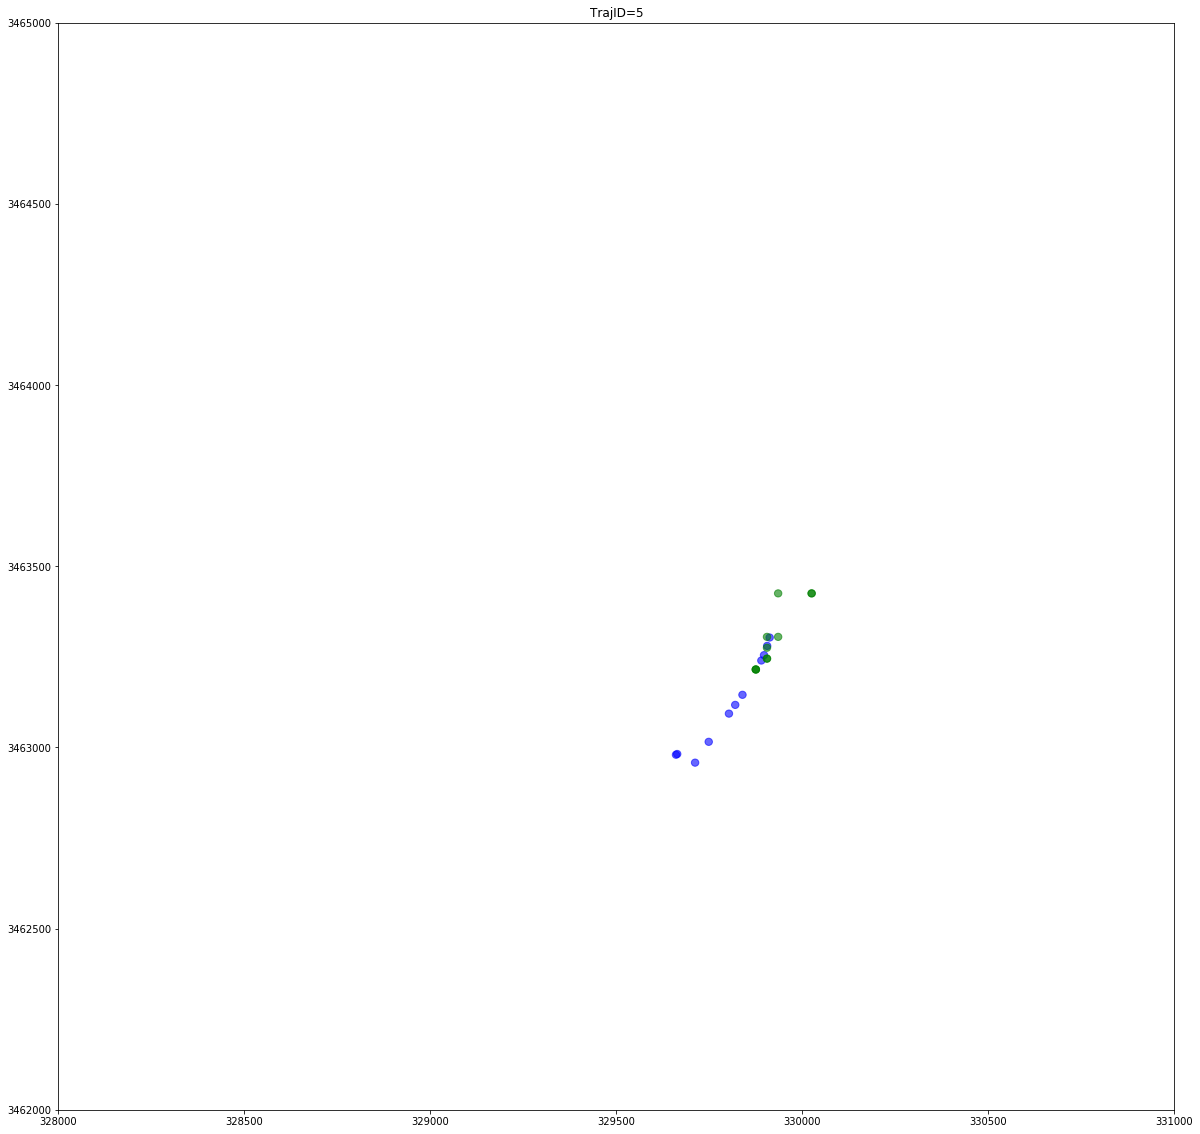

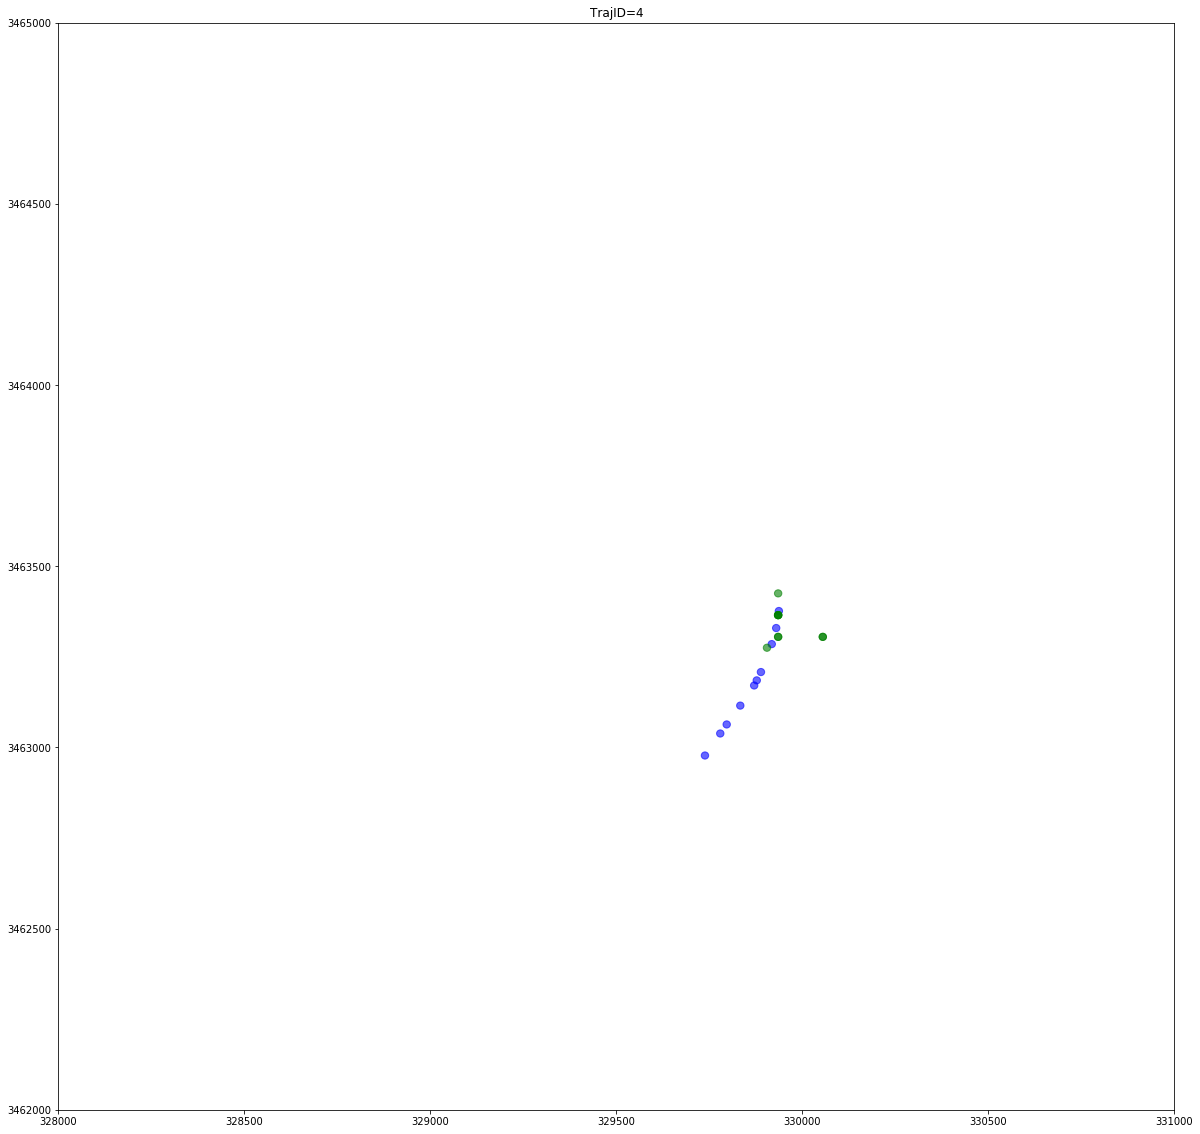

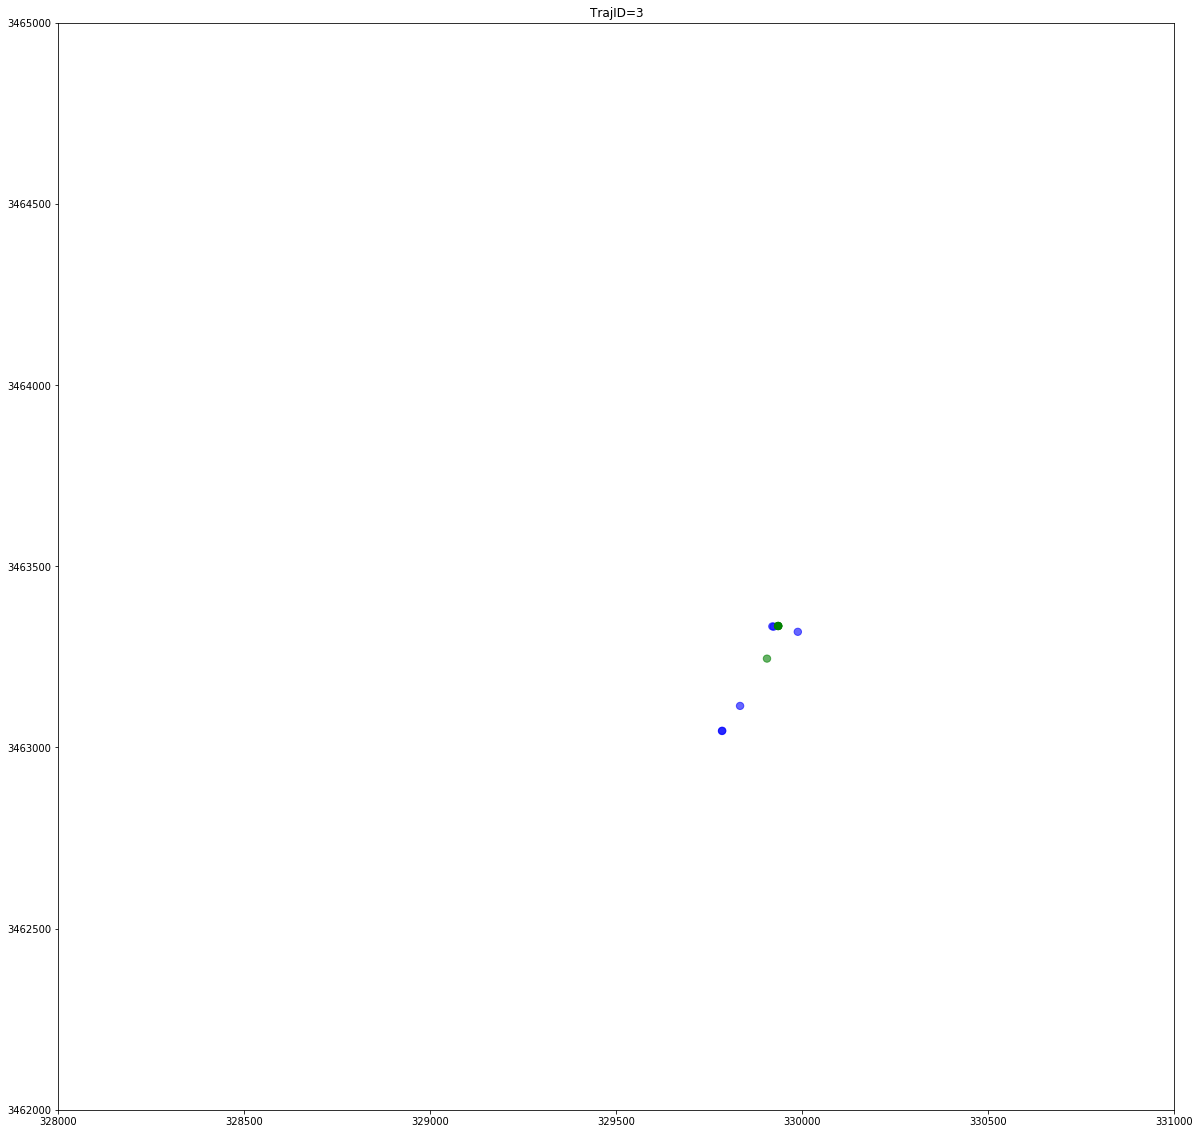

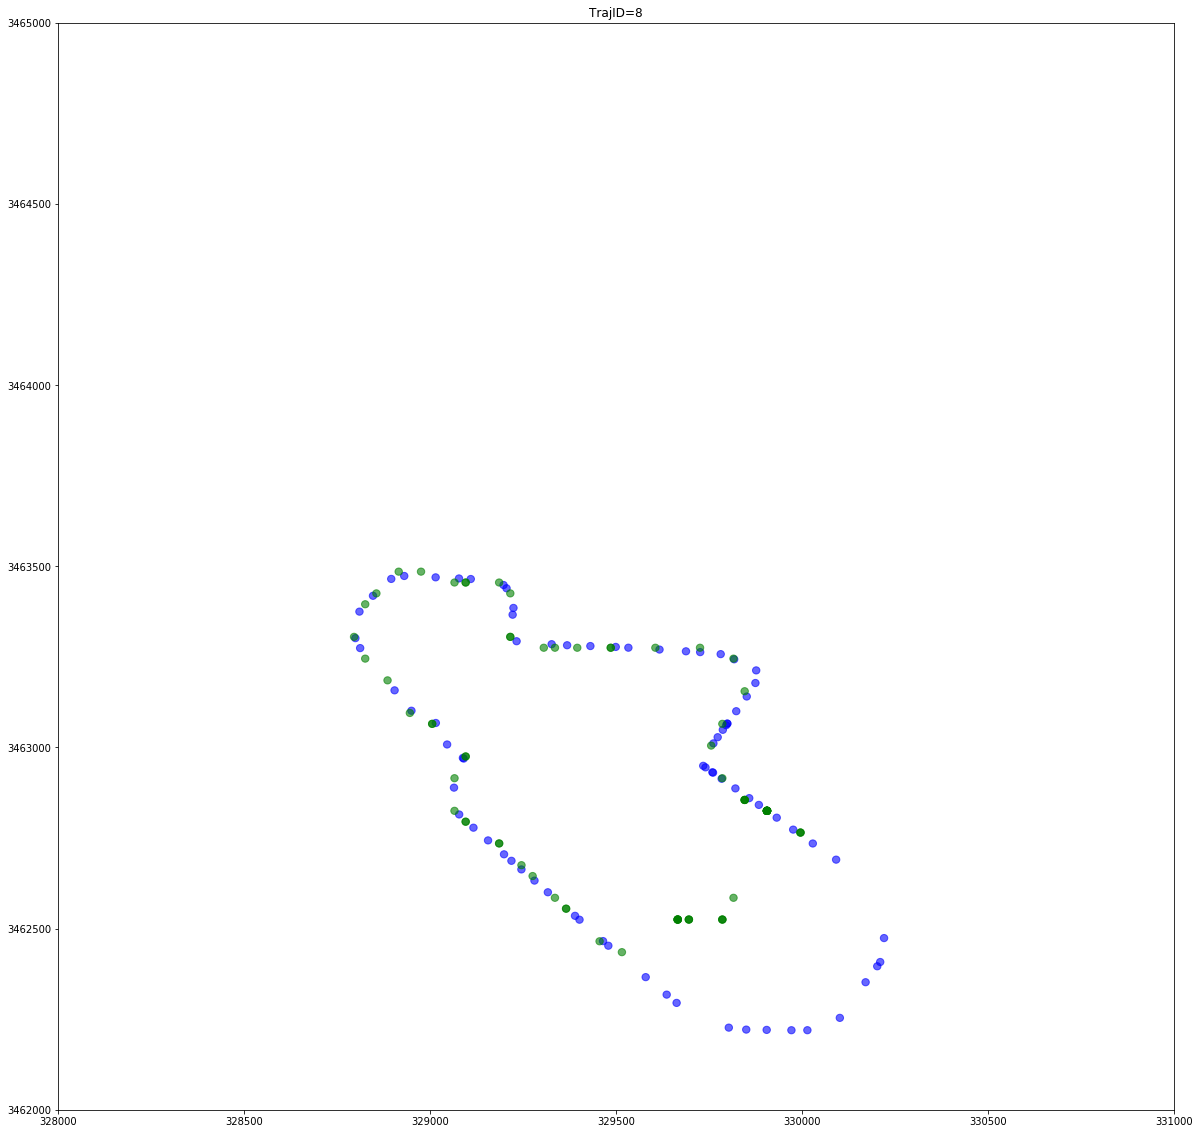

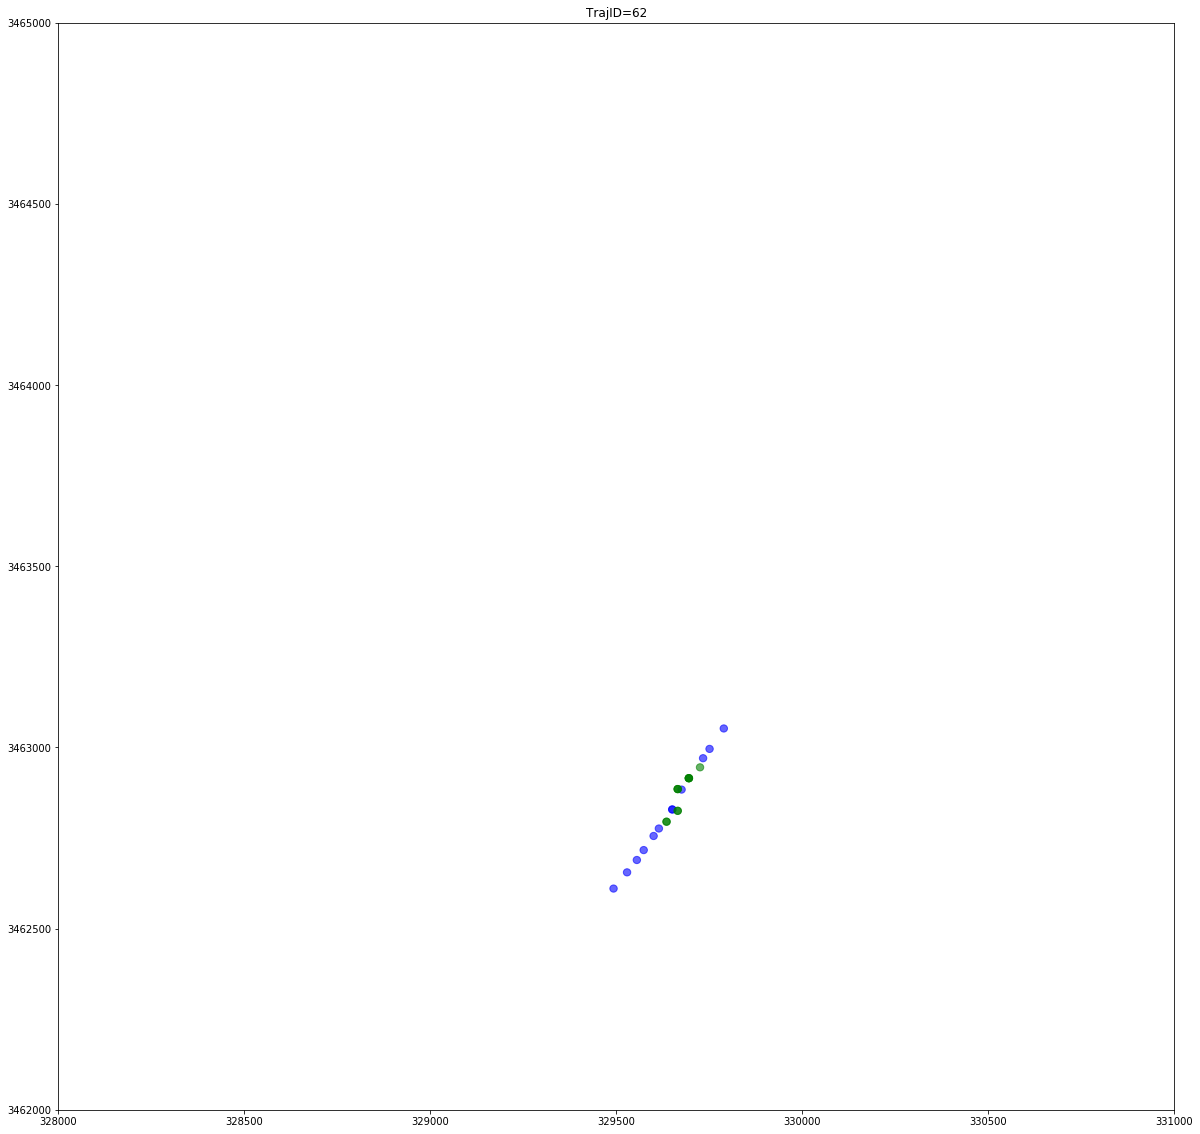

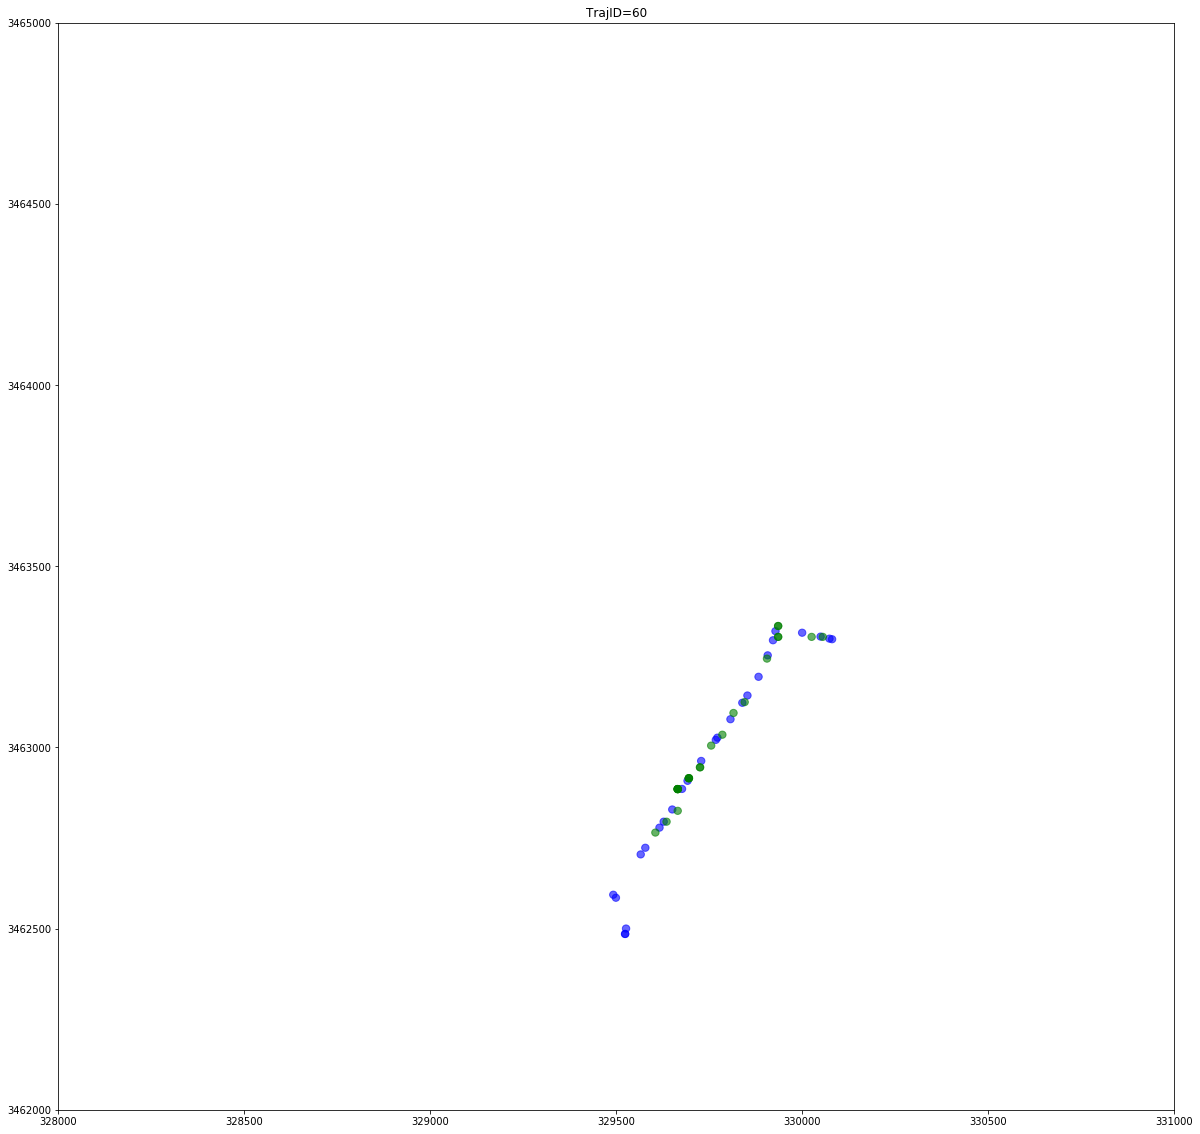

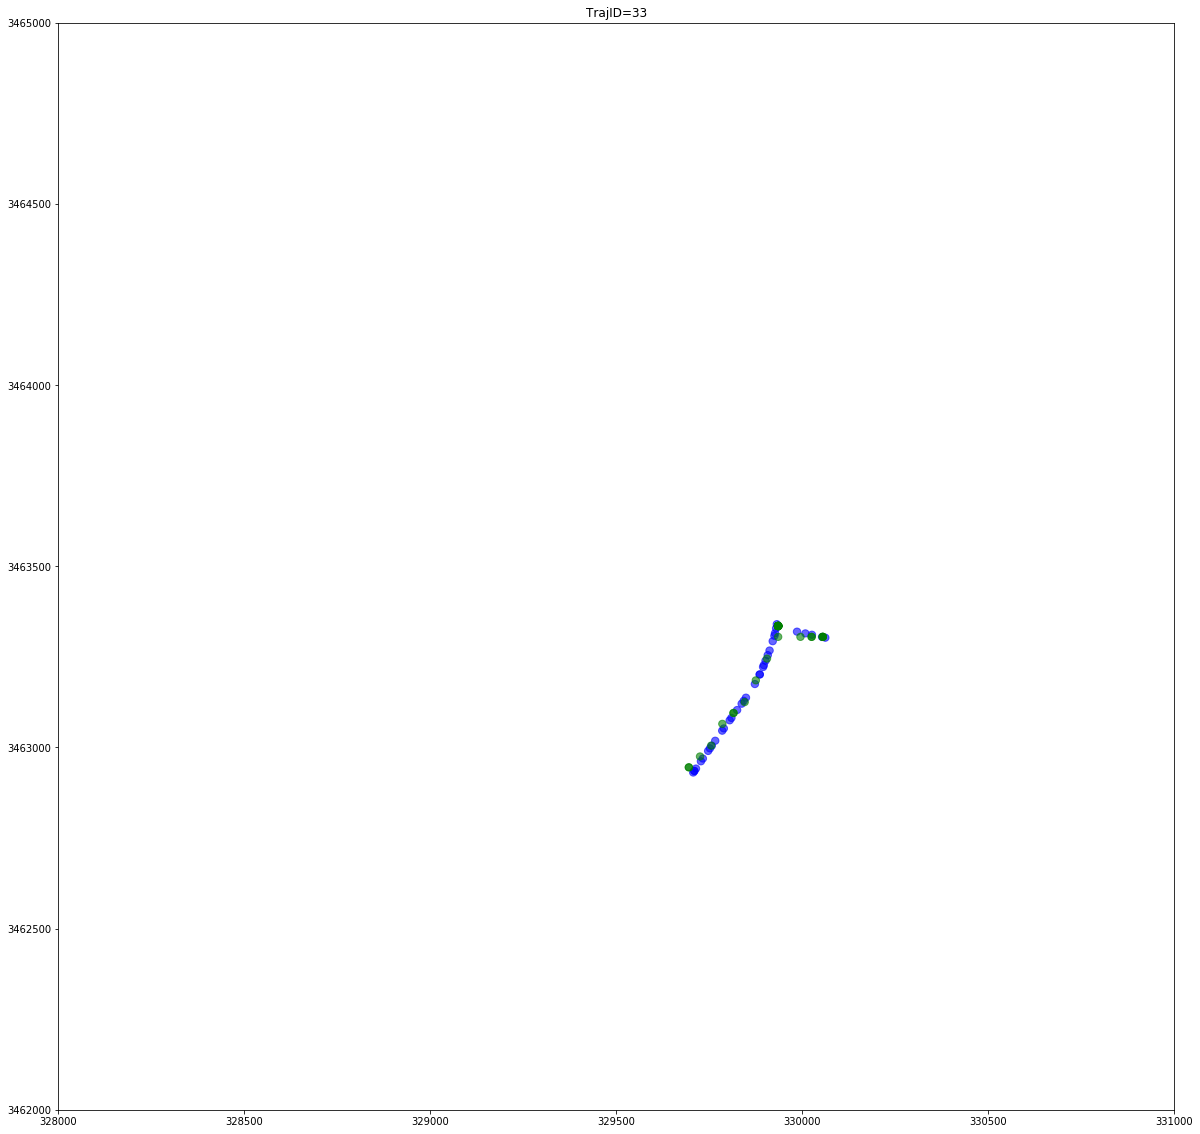

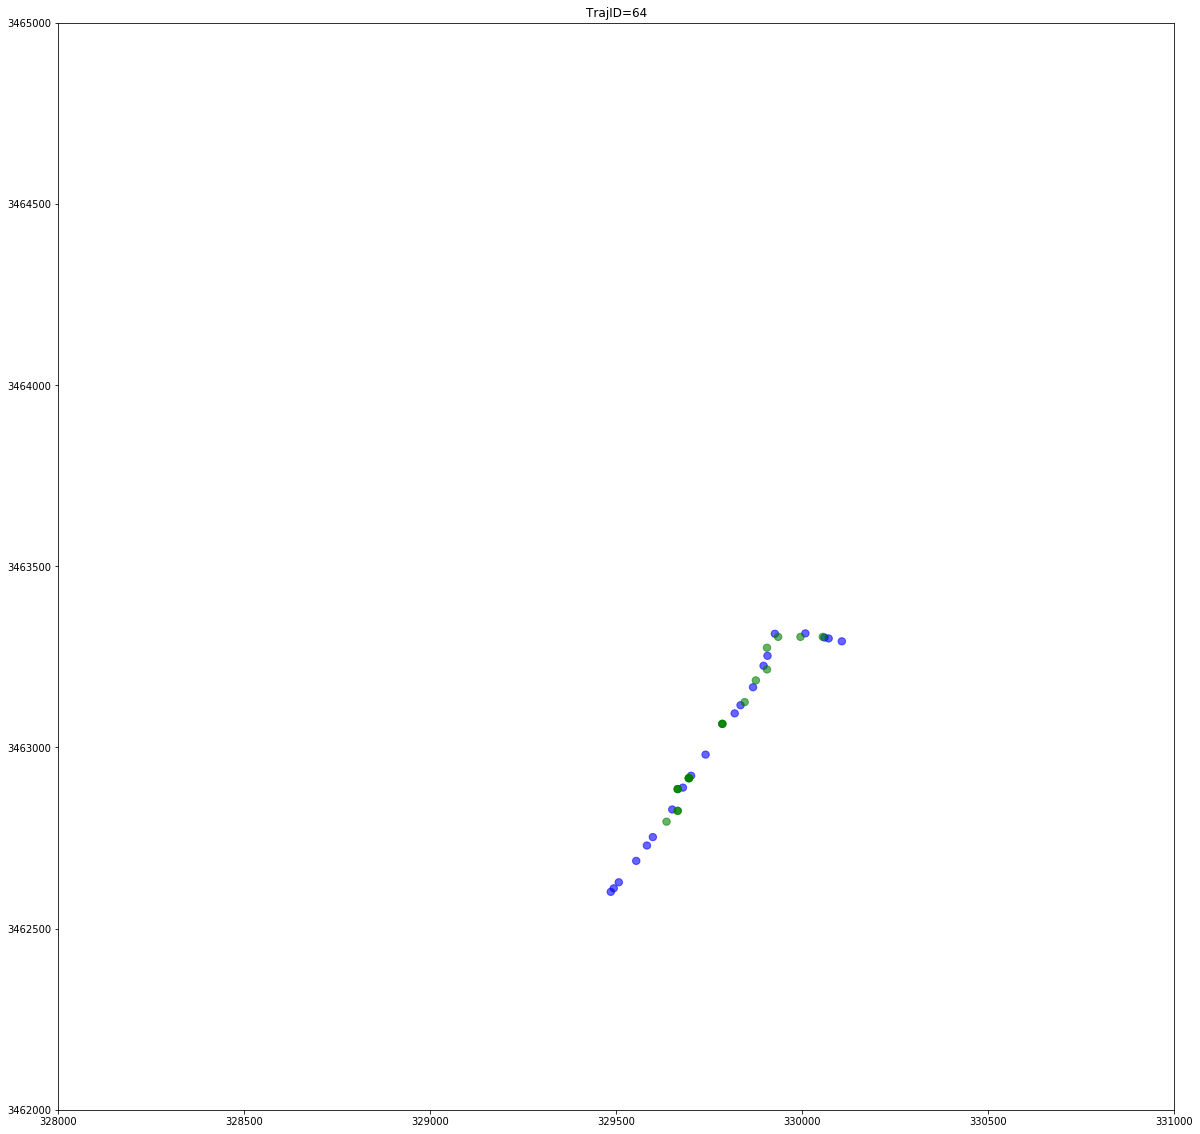

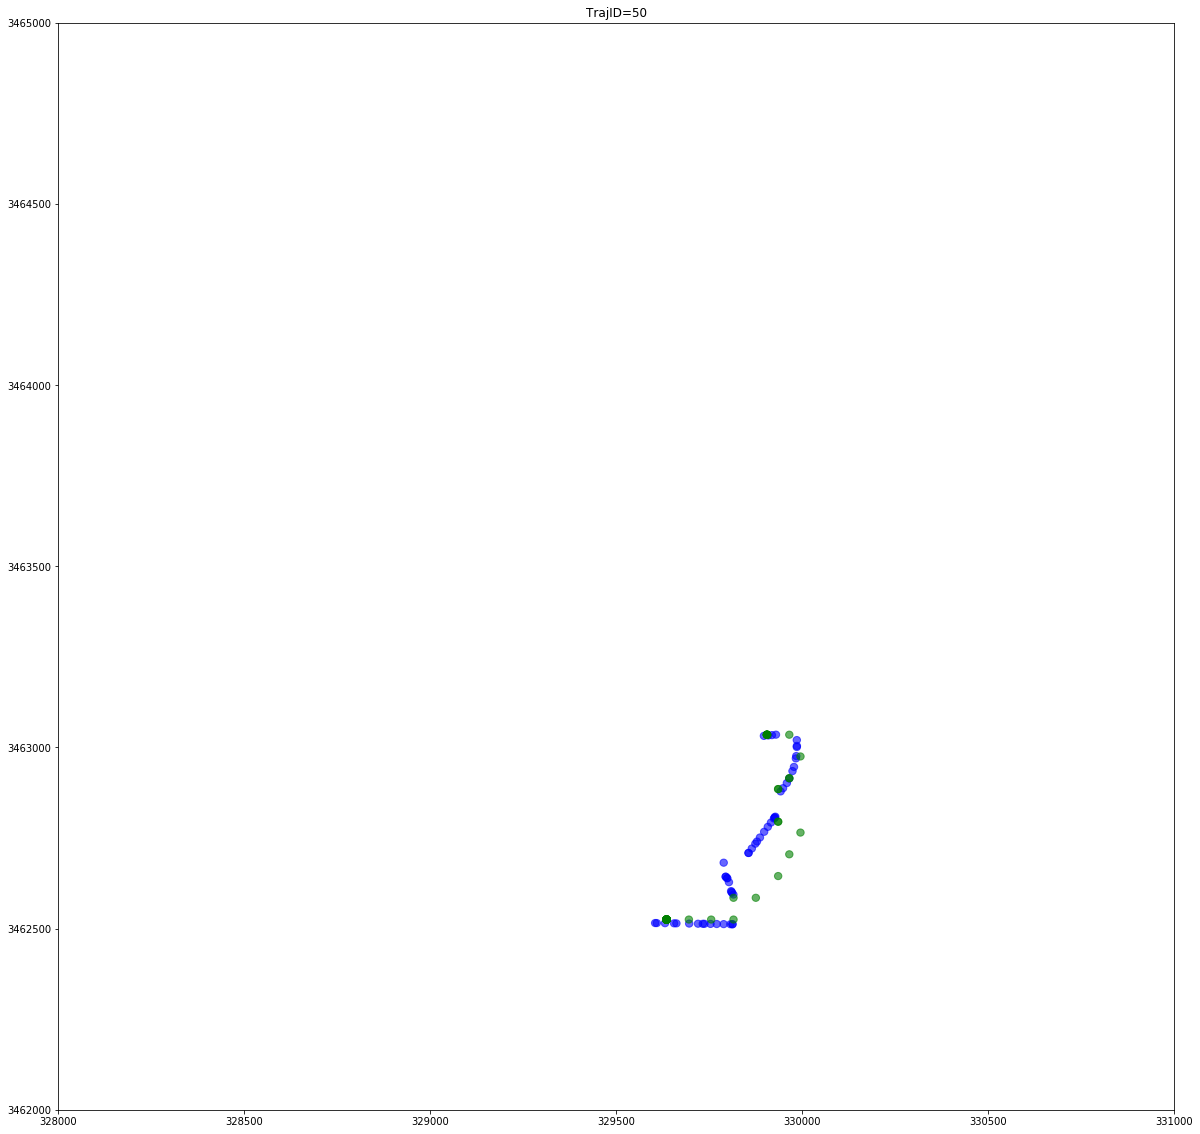

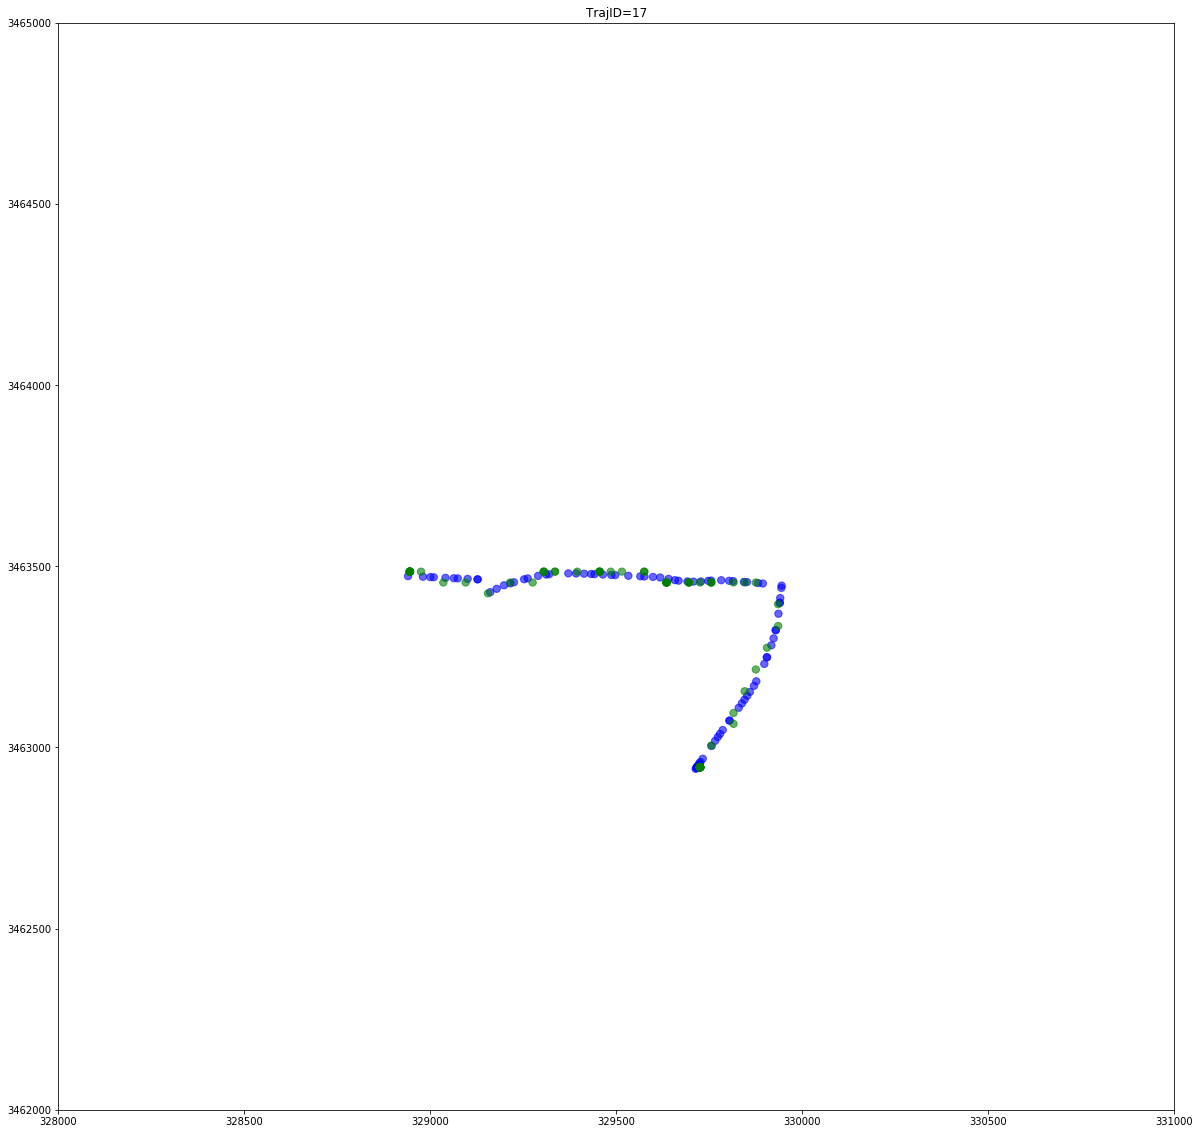

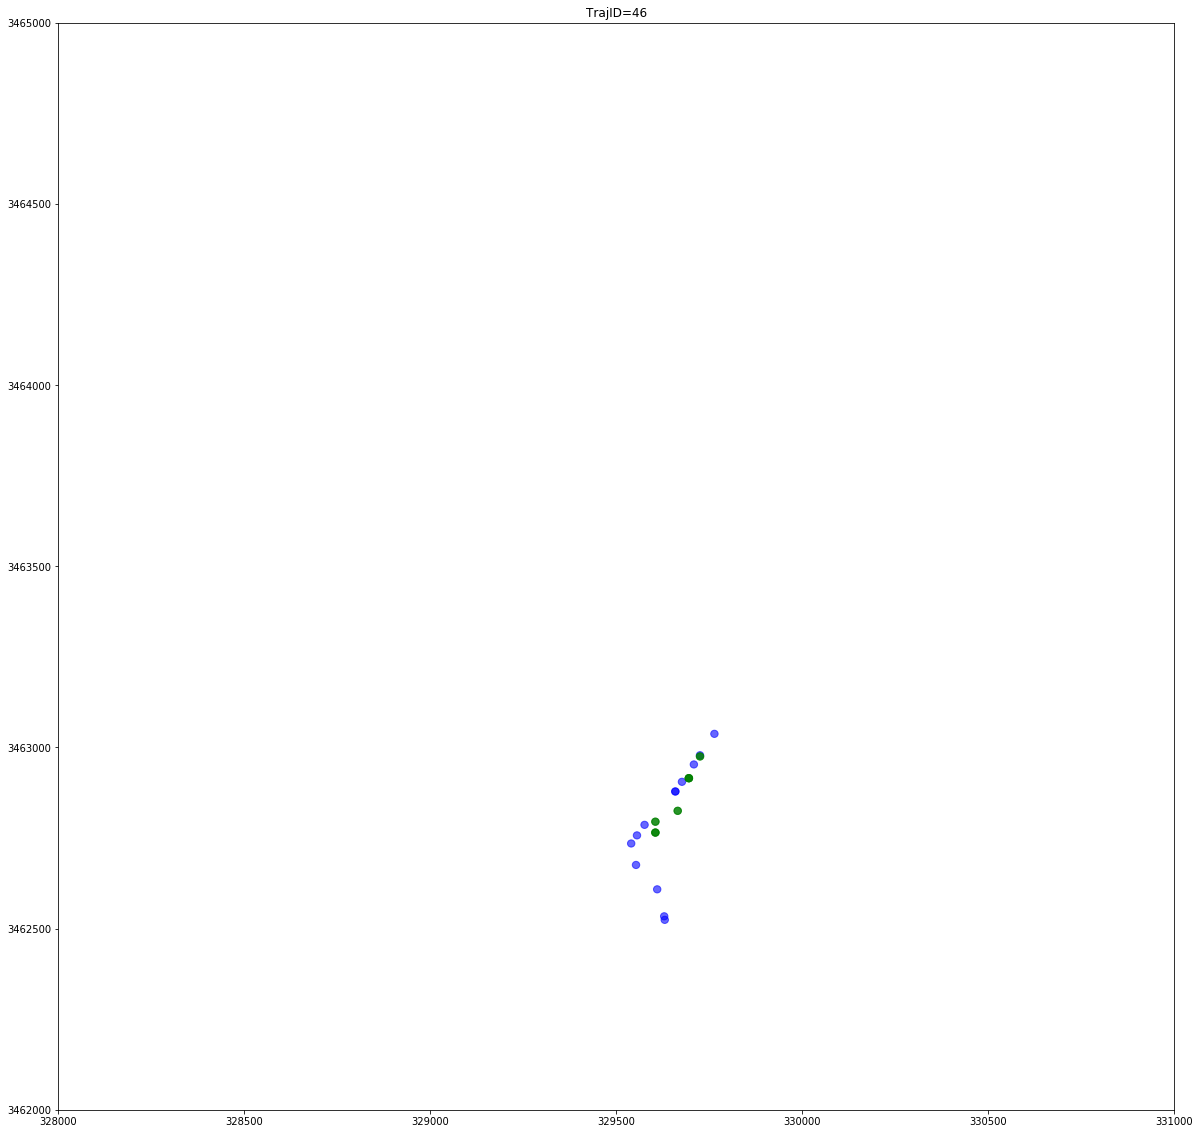

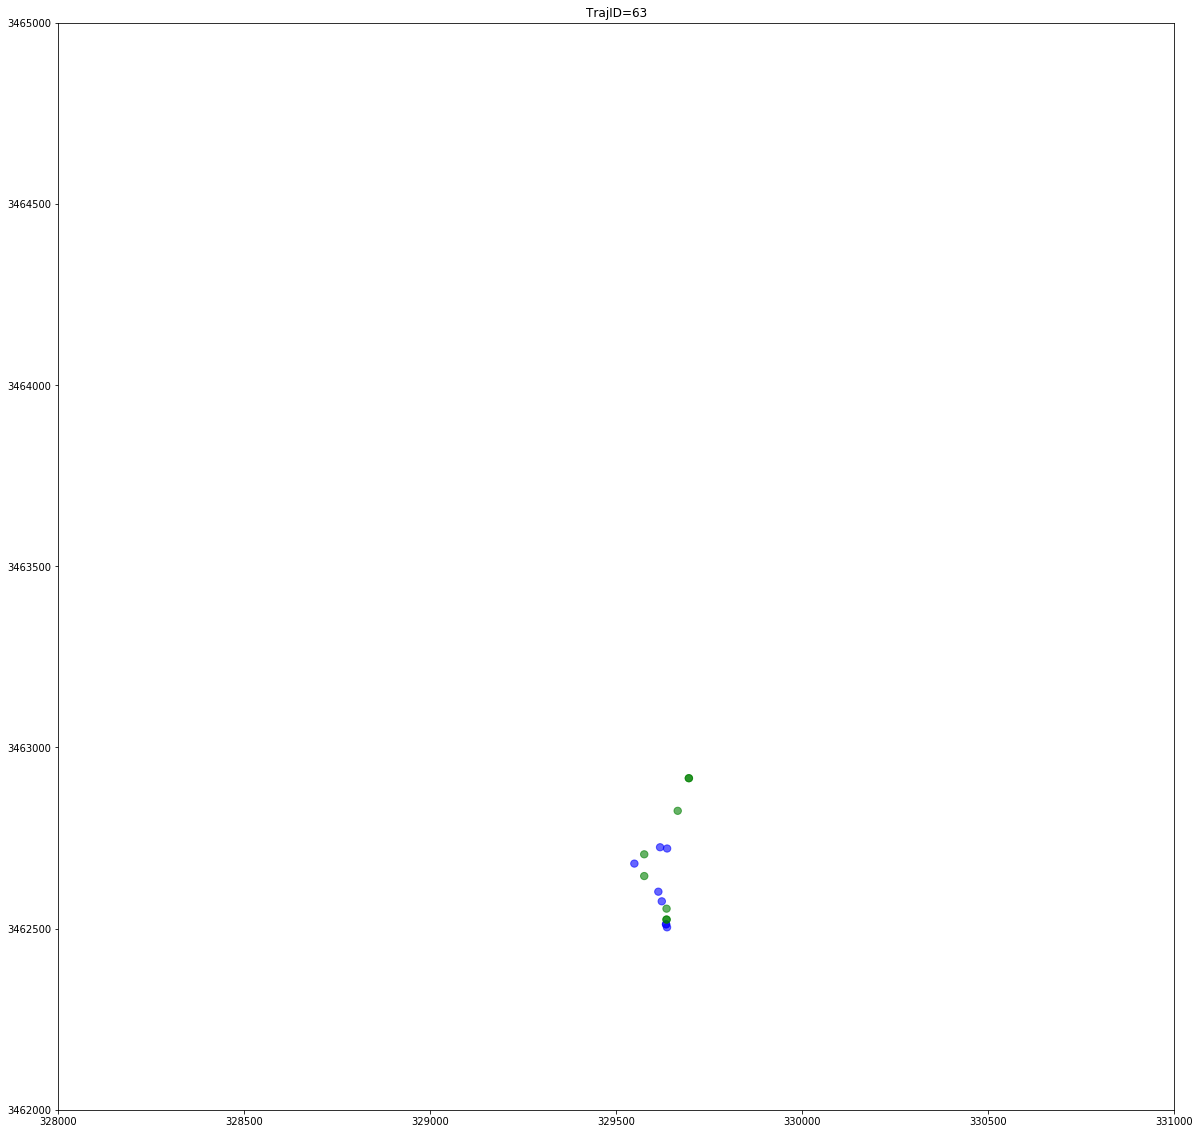

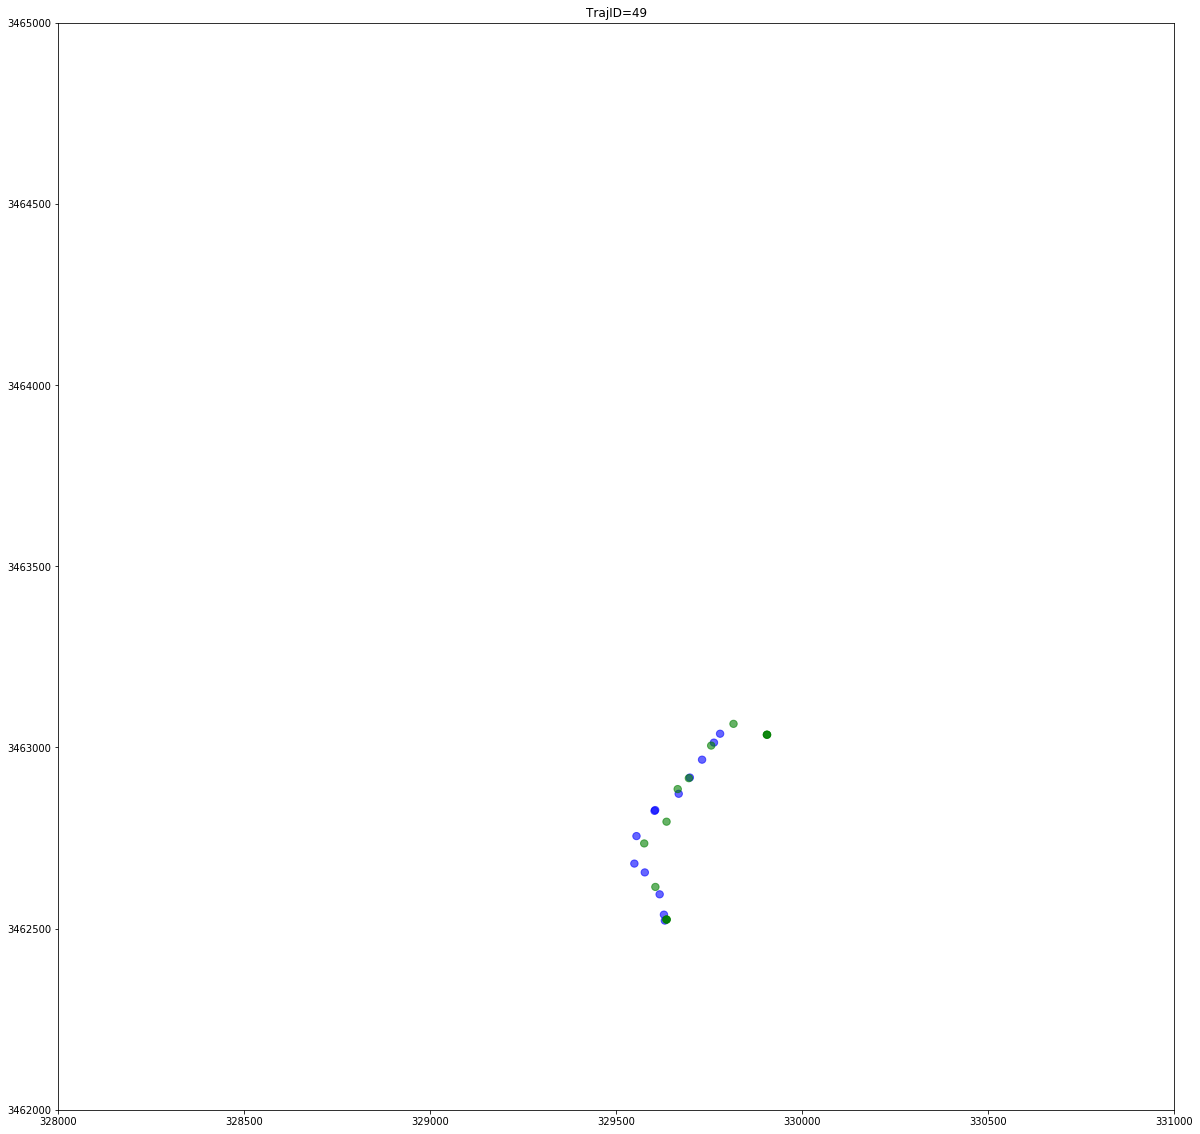

In [184]:
plot = reload(plot)
axis = bounding_box
fig_width = 20
# for tr_id in new_test.iterkeys():
for tr_id in error_ids:
    if tr_id in failed_trajs:
        continue
    plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
    ca = plt.gca()
    plot.draw_cells(uni_cells, ca, axis, debug=False)
    plot.draw_traj_on_cells(sag.utm_test[tr_id], ca, axis, 'b')
    plot.draw_traj_on_cells(sag.utm_pred[tr_id], ca, axis, 'g')
    plt.axis(axis)
    plt.title('TrajID=' + str(tr_id))
    plt.show()
#     plt.savefig(disp_path + 'error/%d.png' % tr_id)
#     plt.close()

## heatmap

In [281]:
import seaborn as sns
obsvs = [(61, 66), (66, 66), (61, 69), (66, 69)]
fig_width = 20
axis = (328500, 330500, 3462000, 3463700)
for obsv in obsvs:
    matrix = [[0 for i in range(90)] for j in range(20, 90)]
    xs, ys = [], []
    for cid in uni_cells.iterkeys():
        x, y = sag.cell2index(cid)
        xs.append(x)
        ys.append(y)
        matrix[y][x] = 0.9
    for cid, prob in B[obsv].iteritems():
        x, y = sag.cell2index(cid)
        matrix[y][x] = prob
    extent = min(xs), max(xs), min(ys), max(ys)
    # print extent
    plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
    cmap = sns.cubehelix_palette(start = 1, rot = 3, gamma=0.8, as_cmap = True)
    ca = plt.gca()
    plt.imshow(matrix, cmap=cmap, origin='lower')
    plt.savefig('./display/other/heatmap-(%d,%d)' % (obsv[0], obsv[1]))
    plt.close()

In [99]:
plot = reload(plot)
axis = (328500, 330500, 3462000, 3463600)
fig_width = 20
plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
ca = plt.gca()
plot.draw_cells(uni_cells, ca, axis, 'k', debug=False)
plot.draw_map(roadmap, ca, axis, debug=False)
plt.axis(axis)
plt.title('side=' + str(side))
plt.savefig(disp_path + 'test%d.png' % side)
plt.close('all')

297


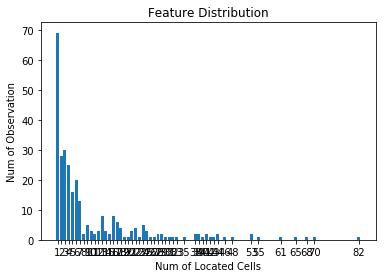

In [41]:
S = dict()
obsv_set = set()
statist = defaultdict(list)
summary = defaultdict(int)
for tr_id, traj in dbs.iteritems():
    for idx, point in enumerate(dbs[tr_id]):
        x, y = point[:2]
        obsv = point[2:-2]
        obsv_set.add(obsv)
        state = sag.utm2cell(x, y)
        if not S.has_key(obsv):
            S[obsv] = dict()
        if not S[obsv].has_key(state):
            S[obsv][state] = 0
        S[obsv][state] += 1
for obsv in S.iterkeys():
    num = len(S[obsv])
    summary[num] += 1
    statist[num].append(obsv)
print len(obsv_set)
plt.bar(summary.keys(), height=summary.values())
xticks = [str(x) for x in summary.keys()]
plt.xticks(summary.keys(), xticks)
plt.title('Feature Distribution')
plt.xlabel('Num of Located Cells')
plt.ylabel('Num of Observation')
plt.show()

In [46]:
plot = reload(plot)
num = 3
fig_width = 20
axis = (328500, 330500, 3462000, 3463600)
for idx, obsv in enumerate(statist[num]):
    plt.figure(figsize=(fig_width, fig_width*(axis[3]-axis[2])/(axis[1]-axis[0])))
    ca = plt.gca()
    cids = S[obsv].keys()
    cells = sag.get_cells(cids)
    plot.draw_cells(cells, ca, axis, plot.colors[idx % len(plot.colors)], debug=False)
#     plot.draw_map(roadmap, ca, axis, debug=False)
    plt.axis(axis)
    plt.title('obsv distribution num=' + str(num))
    plt.savefig(disp_path + 'deepin/obsv_num=%d_idx=%d.png' % (num, idx))
plt.close('all')

In [27]:
np.median(uni_prec)

38.49172838850944

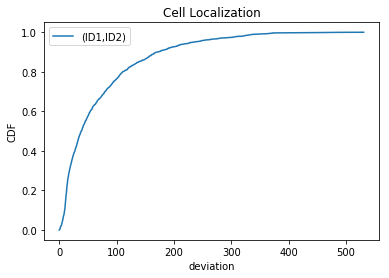

In [30]:
def plot_median(precision, xlabel, ylabel, title):
    count = len(precision)
    X = sorted(precision)
    Y = np.cumsum([1.0/count] * count)
    plt.plot(X, Y)
    plt.legend(['(ID1,ID2)'], loc='best')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
#     plt.savefig('Cell Loc.png')
    plt.show()
plt.close('all')
plot_median(uni_prec, 'deviation', 'CDF', 'Cell Localization')